Loaded 2622 rows (without noise)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 33.91it/s]


Prepared 1834 train sequences, 788 test sequences
Train size: 1834, Test size: 788


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking (Masking)                    │ (None, None, 384)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 270,977 (1.03 MB)

 Trainable params: 270,977 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 42s 570ms/step - loss: 0.1042 - mae: 0.2487 - val_loss: 0.0998 - val_mae: 0.2425
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 31s 536ms/step - loss: 0.0067 - mae: 0.0618 - val_loss: 0.0869 - val_mae: 0.2293
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 31s 541ms/step - loss: 0.0027 - mae: 0.0404 - val_loss: 0.0729 - val_mae: 0.2141
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 30s 521ms/step - loss: 8.0644e-04 - mae: 0.0222 - val_loss: 0.0761 - val_mae: 0.2170
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 32s 552ms/step - loss: 4.3893e-04 - mae: 0.0166 - val_loss: 0.0767 - val_mae: 0.2167
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 31s 536ms/step - loss: 4.0373e-04 - mae: 0.0157 - val_loss: 0.0742 - val_mae: 0.2131
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 31s 540ms/step - loss: 0.0010 - mae: 0.0255 - val_loss: 0.0796 - val_mae: 0.2194
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 32s 551ms/step - loss: 3.0879e-04 - mae: 0.0134 - val_loss: 0.0749 - val_mae: 0.2127
Epoch 9/10
58/58 ━━━━━━━━━━━━━━━

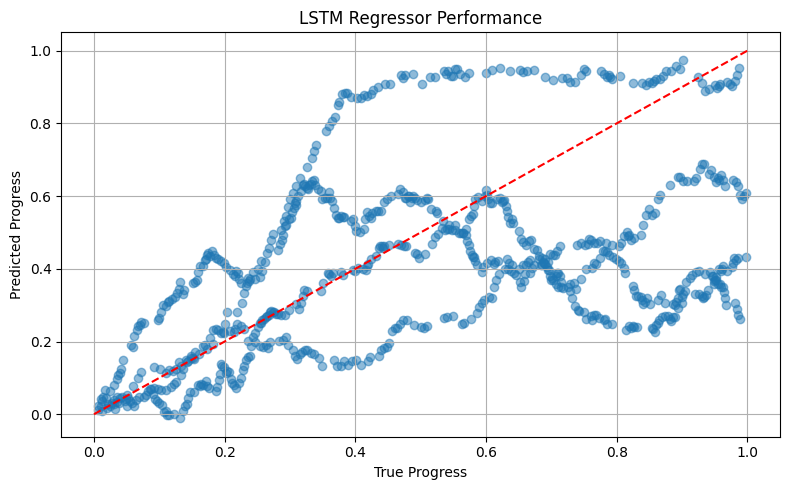

In [1]:
# Import
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Params
INPUT_PATH = "./progress_added.csv"
EMBED_DIM = 384   # MiniLM embedding size

# Load data
df = pd.read_csv(INPUT_PATH)
df = df[df["cluster"] != -1]
df = df[df["text"].notnull() & df["text"].str.strip().astype(bool)]
print(f"Loaded {len(df)} rows (without noise)")

# Prepare sequences

# convert embedding string to list
df["embedding"] = df["embedding"].apply(lambda x: np.array(eval(x), dtype=np.float32))

all_files = df["file"].unique()
train_files, test_files = train_test_split(all_files, test_size=0.2, random_state=42)

X_train, y_train, X_test, y_test = [], [], [], []

for file_name, group in tqdm(df.groupby("file")):
    group = group.sort_values("start_sec")
    
    sequence = []
    for i, row in group.iterrows():
        sequence.append(row["embedding"])
        if file_name in train_files:
            X_train.append(sequence.copy())
            y_train.append(row["progress_label"])
        else:
            X_test.append(sequence.copy())
            y_test.append(row["progress_label"])

print(f"Prepared {len(X_train)} train sequences, {len(X_test)} test sequences")

# Pad sequences
X_train = pad_sequences(X_train, dtype='float32', padding='post')
X_test = pad_sequences(X_test, dtype='float32', padding='post')

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

# Build LSTM model
# model = models.Sequential([
#     layers.Masking(mask_value=0.0, input_shape=(None, EMBED_DIM)),
#     layers.LSTM(128, return_sequences=False),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(1, activation='linear')
# ])
model = models.Sequential([
    layers.Input(shape=(None, EMBED_DIM)),
    layers.Masking(mask_value=0.0),
    layers.LSTM(128),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

model.summary()

# Train
history = model.fit(
    X_train, np.array(y_train),
    validation_data=(X_test, np.array(y_test)),
    epochs=10,
    batch_size=32
)

# Predict
y_pred = model.predict(X_test).flatten()

# Metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nMSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel("True Progress")
plt.ylabel("Predicted Progress")
plt.title("LSTM Regressor Performance")
plt.grid(True)
plt.tight_layout()
plt.show()

# model.export("progress_lstm_model")
# print("Model saved to progress_lstm_model")